<a href="https://colab.research.google.com/github/yasmine-mk/latent-factor-recommender-system/blob/main/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# importing packages
import pandas as pd
import numpy as np
from math import sqrt 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

## Reading the Dataset 

In [31]:
# read the rating dataframe
data = pd.read_csv('ratings.csv')
# read the item dataframe
item = pd.read_csv('movies.csv')

In [48]:
print(item.info())
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB
None


## Generating utility Matrix R

In [32]:
# pre-processing data
data.drop('timestamp',axis=1,inplace=True)

In [33]:
data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [34]:
# generating matrix 
matrix_df = data.pivot_table(index='userId',columns='movieId',values='rating')
matrix_df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 ### preprocessing data

In [35]:
# filtering out rare movies 
# first we specify the number of NULL values required to remove the row or column
perc = 65.0 # Like N %
min_count =  int(((100-perc)/100)*matrix_df.shape[0] + 1)
matrix_df = matrix_df.dropna( axis=1, 
                thresh=min_count)

In [36]:
matrix_df

movieId,1,110,260,296,318,356,480,527,589,593,2571,2959
userId,,,,,,,,,,,,
1,4.0,4.0,5.0,3.0,NaN,4.0,4.0,5.0,NaN,4.0,5.0,5.0
2,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN
4,NaN,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,2.0
5,4.0,4.0,NaN,5.0,3.0,NaN,NaN,5.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,3.5,4.5,5.0,3.5,4.0,2.5,5.0,3.5,4.5,5.0,5.0
607,4.0,5.0,3.0,3.0,5.0,NaN,4.0,5.0,4.0,5.0,5.0,NaN
608,2.5,4.0,3.5,5.0,4.5,3.0,3.0,4.0,3.0,4.0,5.0,5.0


In [37]:
# rename the column header 
item_list=list(matrix_df.columns)
item_name_list=[]
for item_id in item_list:
  item_name=(item[item['movieId']==item_id]['title'].values[0])
  item_name_list.append(item_name)
item_name_list
# replace the movieId with movie name
matrix_df.set_axis(item_name_list, axis=1,inplace=True)
# fill the NaN with 0
matrix = matrix_df.fillna(0).values
# look into the shape of matrix
display(matrix_df)

,Toy Story (1995),Braveheart (1995),Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994),"Shawshank Redemption, The (1994)",Forrest Gump (1994),Jurassic Park (1993),Schindler's List (1993),Terminator 2: Judgment Day (1991),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Fight Club (1999)
userId,,,,,,,,,,,,
1,4.0,4.0,5.0,3.0,NaN,4.0,4.0,5.0,NaN,4.0,5.0,5.0
2,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN
4,NaN,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,2.0
5,4.0,4.0,NaN,5.0,3.0,NaN,NaN,5.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,3.5,4.5,5.0,3.5,4.0,2.5,5.0,3.5,4.5,5.0,5.0
607,4.0,5.0,3.0,3.0,5.0,NaN,4.0,5.0,4.0,5.0,5.0,NaN
608,2.5,4.0,3.5,5.0,4.5,3.0,3.0,4.0,3.0,4.0,5.0,5.0


![link text](https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/mf.png)
Our Matrix R has the shape (m,n) 
where m is the number of users and n the number of items

> Indented block


* $R=P ⋅ Q^{T} $
  * $P = row-wised =dimension(m·r)$ 
  * $Q^{T} = column-wised =dimension(r·n)$ 
    * P = dimension(n.r)
  * r = num of Latent Factors Chosen

* To Avoid Overfitting, we use L2 Regularization 
  * $λ = regularization factor$


* So, The Cost Function = MSE + $λ · L2_{norm}$

---

## Stochastic Gradient Descent (Minimize the Cost Function)
* Optimization = Gradient Descent ($α$ = learning rate) Update $p_u, q_i$ (for $r_{ui}$ ! = 0)
  * The Gradient Descent per Iteration (Only Update for Non-Zero Value in Matrix R)
  * For each Epoch:
    * --- Update $p_u \leftarrow p_u + α \cdot [q_i (r_{ui} - p_u \cdot q_i) - λ\cdot p_u]$
    * --- Update $q_i \leftarrow q_i + α \cdot [p_u (r_{ui} - p_u \cdot q_i) - λ\cdot q_i]$
  * Meaning of $p_u, q_i$:
    * $p_u$ = row u of P
    * $q_i$ = row i of Q


In [38]:
# extract the non-zero index for matrix
## np.nonzero() = Return the indices of the elements that are non-zero.
users, items=matrix.nonzero()
m, n = matrix.shape

# set the hyperparameters
X_train=matrix

n_latent_features=4
# initialize P and Q 
P = np.random.rand(m,n_latent_features)
Q = np.random.rand(n,n_latent_features)

In [39]:
# look into the shape of P and Q
print(P.shape)
print(Q.shape)

(610, 4)
(12, 4)


In [40]:
# function for predictions
def predictions(P, Q):
    return P@Q.T

# function to calculate the rmse
def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)


![link text](
)


In [41]:
# Run the Grad Des for P,Q Updating
def gradient_train(n_epochs,lmbda,learning_rate):
  train_error = []
  for epoch in range(n_epochs):
    for u, i in zip(users, items):
        error = X_train[u, i] - np.dot(P[u, :], Q[i, :])
        P[u, :] = P[u, :] + learning_rate * (error * Q[i, :] - lmbda * P[u, :])
        Q[i, :] = Q[i, :] + learning_rate * (error * P[u, :] - lmbda * Q[i, :] )

    train_mse = mse(predictions(P,Q), X_train)
    train_error.append(train_mse)
  return P,Q,train_error

In [42]:
# Run the Stochastic Gradient Descent
P,Q,train_error=gradient_train(n_epochs=100,lmbda=0.1,learning_rate=0.005)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The Final MSE = 0.41510047709592945


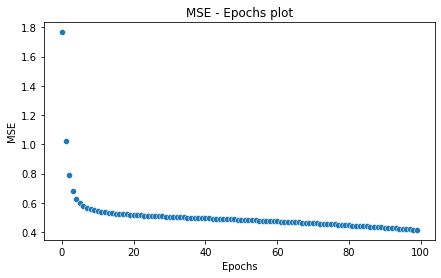

In [43]:
# plot the rmse vs epoch
def plot_rmse_epoch(): 
  x=range(len(train_error))
  y=train_error
  # graph
  fig,ax1=plt.subplots(1,1,figsize=(7,4))
  sns.scatterplot(x,y,ax=ax1)
  ax1.set_title('MSE - Epochs plot')
  ax1.set(xlabel='Epochs',ylabel='MSE')

  # the final mse
  final_mse=min(train_error)
  print(f'The Final MSE = {final_mse}')
  return final_mse

# plot
final_mse=plot_rmse_epoch()

In [44]:
# display the prediction matrix result
def pred_result():
  prediction_matrix=predictions(P,Q)
  prediction_matrix_df=matrix_df.copy()
  prediction_matrix_df[:]=prediction_matrix
  # combine the prediction and original matrix (replace the prediction rate with some existing rate )
  for row,col in zip(users, items):
    prediction_matrix_df.iloc[row,col]=matrix[row,col]
  return prediction_matrix_df

In [45]:
# The Prediction matrix result
prediction_matrix_df=pred_result()
prediction_matrix_df

,Toy Story (1995),Braveheart (1995),Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994),"Shawshank Redemption, The (1994)",Forrest Gump (1994),Jurassic Park (1993),Schindler's List (1993),Terminator 2: Judgment Day (1991),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Fight Club (1999)
userId,,,,,,,,,,,,
1,4.000000,4.000000,5.000000,3.000000,4.500262,4.000000,4.000000,5.000000,4.372078,4.000000,5.000000,5.000000
2,2.315885,2.412135,2.675113,2.677865,3.000000,2.443395,2.487652,2.633007,2.507179,2.732406,2.499454,2.897585
3,0.684947,0.315256,0.372224,0.812904,0.595794,0.497984,0.245475,0.500000,0.231537,0.546292,0.430888,0.520807
4,2.607670,2.471652,5.000000,1.000000,3.001841,2.892811,2.869613,3.106877,2.899695,5.000000,1.000000,2.000000
5,4.000000,4.000000,3.881520,5.000000,3.000000,3.663202,3.307045,5.000000,3.000000,4.095637,4.086725,4.284166
...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.500000,3.500000,4.500000,5.000000,3.500000,4.000000,2.500000,5.000000,3.500000,4.500000,5.000000,5.000000
607,4.000000,5.000000,3.000000,3.000000,5.000000,4.231194,4.000000,5.000000,4.000000,5.000000,5.000000,4.408875
608,2.500000,4.000000,3.500000,5.000000,4.500000,3.000000,3.000000,4.000000,3.000000,4.000000,5.000000,5.000000


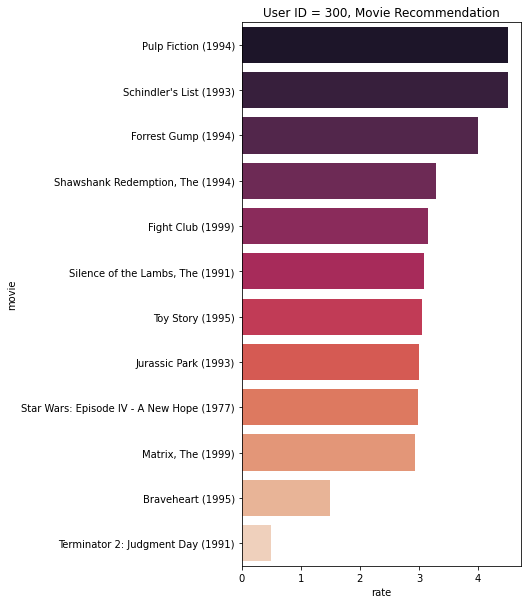

In [51]:
# input = user_id, output =  Recommend Movie
def recommend_by_user(user_id):
  user_rate=prediction_matrix_df.iloc[user_id,:].to_frame(name='rate')
  user_rate['movie'] = user_rate.index
  user_rate.sort_values(by=['rate'],ascending=False,inplace=True)
  user_rate.reset_index(drop=True,inplace=True)
  # plot
  fig,ax1=plt.subplots(1,1,figsize=(5,10))
  sns.barplot(data=user_rate,y='movie',x='rate',palette="rocket",ax=ax1)
  ax1.set_title(f'User ID = {user_id}, Movie Recommendation')
  return user_rate

# run the func
user_rate=recommend_by_user(user_id=300)